In [6]:
import gym
import gym_simple
import matplotlib.pyplot as plt
import numpy as np
import time

%matplotlib inline

In [2]:
# State description/ Observation:
# Agent position (x,y)
# Ball position (x,y)
# Box position (x,y)
# Agent holding: 0-Nothing, 1-Ball, 2-Box
# Format: [x1,y1,x2,y2,x3,y3,z]
actions = ['move-up', 'move-down', 'move-left', 'move-right', 'move-up-right',
    'move-up-left', 'move-down-right', 'move-down-left', 'pick-up', 'put-down']

move_actions = actions[0:8]

r_actions = ['go-to-ball', 'go-to-box', 'pick-up-ball', 'pick-up-box',
    'put-down-ball', 'put-down-box']
# R-State description
# Agent to Ball distance in steps
# Agent to Box distance in steps
# Agent holding Ball
# Agent holding Box

In [3]:
def move(position, move_action):
    """
    Returns a new position after a move in some direction
    """
    x, y = position.values()
    if move_action in ['move-up', 'move-up-right', 'move-up-left']:
        x -= 1 # Moves up
    elif move_action in ['move-down', 'move-down-right', 'move-down-left']:
        x += 1 # Moves down
    if move_action in ['move-left', 'move-up-left', 'move-down-left']:
        y -= 1 # Moves left
    elif move_action in ['move-right', 'move-up-right', 'move-down-right']:
        y +=1  # Moves right
    return {'x':x, 'y':y}

def distance_in_moves(position_a, position_b):
    """
    Returns the distance in moves between two positions
    """
    if abs(position_a['x'] - position_b['x']) > \
        abs(position_a['y'] - position_b['y']):
        return abs(position_a['x'] - position_b['x'])
    else:
        return abs(position_a['y'] - position_b['y'])

def go_to(position_a, position_b):
    """
    Returns next move action(s) to go from position a to position b
    """
    distance_in_moves_a_b = distance_in_moves(position_a, position_b)
    if position_a == position_b:
        return None
    else:
        # returns move actions that decrease distance between a and b
        return [move_action for move_action in move_actions
                if distance_in_moves(move(position_a, move_action),position_b) <
                distance_in_moves_a_b]

In [4]:
# Get the action to take following the optimal policy
# and taking one of 4 r-actions at each time step:
def get_optimal_action(observation, policy):
    """
    Returns a primitive action following the optimal Policy
    """
    agent_pos = {'x': observation[0], 'y': observation[1]}
    ball_pos = {'x': observation[2], 'y': observation[3]}
    box_pos = {'x': observation[4], 'y': observation[5]}
    agent_holding_ball = False
    agent_holding_box = False
    if observation[6] == 1:
        agent_holding_ball = True
    elif observation[6] == 2:
        agent_holding_box = True
    if policy == 'go_to_ball':
        if distance_in_moves(agent_pos, ball_pos) > 0:
            return np.random.choice(go_to(agent_pos, ball_pos)), policy
        elif distance_in_moves(agent_pos, ball_pos) == 0 and agent_holding_ball is False:
            return 'pick-up', policy
        elif agent_holding_ball is True and distance_in_moves(agent_pos, box_pos) > 0:
            return np.random.choice(go_to(agent_pos, box_pos)), policy
        elif agent_holding_ball is True and distance_in_moves(agent_pos, box_pos) == 0:
            return 'put-down', policy
    else:
        if distance_in_moves(agent_pos, box_pos) > 0:
            return np.random.choice(go_to(agent_pos, box_pos)), policy
        elif distance_in_moves(agent_pos, box_pos) == 0 and agent_holding_box is False:
            return 'pick-up', policy
        elif agent_holding_box is True and distance_in_moves(agent_pos, ball_pos) > 1:
            return np.random.choice(go_to(agent_pos, ball_pos)), policy
        elif agent_holding_box is True and distance_in_moves(agent_pos, ball_pos) == 1:
            # Now has to change the policy and go to the ball
            new_policy = 'go_to_ball'
            return 'put-down', new_policy

# Define Optimal Policy relative to the initial state
def get_optimal_policy(observation):
    """
    Return the optimal policy description:
    (First) go to ball or go to box
    """
    agent_pos = {'x': observation[0], 'y': observation[1]}
    ball_pos = {'x': observation[2], 'y': observation[3]}
    box_pos = {'x': observation[4], 'y': observation[5]}
    # Optimal Policy
    # If ball is closer to the agent less than 2 steps more than the box,
    # agent goes to the ball first
    if distance_in_moves(agent_pos, ball_pos) <= \
        distance_in_moves(agent_pos, box_pos) + 2:
        return 'go_to_ball'
    # Agent goes to the box first
    else:
        return 'go_to_box'

# Define Optimal goal state relative to the initial state
def get_optimal_goal_state(initial_observation):
    """
    Returns the state where the goal is reached in the minimum amount of steps
    """
    agent_pos = {'x': observation[0], 'y': observation[1]}
    ball_pos = {'x': observation[2], 'y': observation[3]}
    box_pos = {'x': observation[4], 'y': observation[5]}
    if distance_in_moves(agent_pos, ball_pos) <= \
        distance_in_moves(agent_pos, box_pos) + 2:
        # The agent will be where the box initially is, with the ball there too,
        # not holding anything
        return [box_pos,box_pos,box_pos,0]
    else:
        # The agent will be in the neighbourhood, of the initial position
        # of the ball, closer to the initial position of the box,
        # with the box there too, not holding anything
        while 1:
            if distance_in_moves(box_pos, ball_pos) == 1:
                break
            else:
                box_pos = move(box_pos,np.random.choice(go_to(box_pos, ball_pos)))
        return [box_pos,box_pos,box_pos,0]

In [8]:
# Test optimal policy
env = gym.make('PutBallInBoxEnvRandom8x8-v0')

test_episodes = 10
n_steps = 50

cum_avg_reward_lst = []
total_reward = 0
for i_episode in range(test_episodes):
    print("Episode " + str(i_episode + 1))
    observation,_,_,_ = env.reset()
    policy = get_optimal_policy(observation)
    for t in range(n_steps):
        env.render()
        action_str, policy = get_optimal_action(observation, policy)
        action = actions.index(action_str)
        observation, reward, done, info = env.step(action)
        total_reward += reward
        if done:
            print("Reached the goal after {} timesteps".format(t+1))
            break
        time.sleep(0.5)
    cum_avg_reward = total_reward/(i_episode + 1)
    cum_avg_reward_lst.append(cum_avg_reward)
    print(cum_avg_reward)

Episode 1
Reached the goal after 5 timesteps
96.0
Episode 2
Reached the goal after 5 timesteps
96.0
Episode 3
Reached the goal after 8 timesteps
95.0
Episode 4
Reached the goal after 11 timesteps
93.75
Episode 5
Reached the goal after 9 timesteps
93.4
Episode 6
Reached the goal after 4 timesteps
94.0
Episode 7
Reached the goal after 12 timesteps
93.28571428571429
Episode 8
Reached the goal after 6 timesteps
93.5
Episode 9
Reached the goal after 11 timesteps
93.11111111111111
Episode 10
Reached the goal after 11 timesteps
92.8


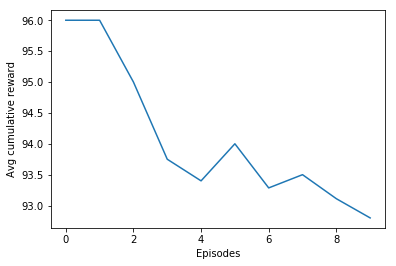

In [9]:
plt.plot(cum_avg_reward_lst)
plt.ylabel('Avg cumulative reward')
plt.xlabel('Episodes')
plt.show()